In [1]:
import numpy as np
import mdtraj as md
import matplotlib.pyplot as plt
import nglview as nv
import networkx as nx

# https://biopython.org/docs/1.74/api/Bio.SVDSuperimposer.html
# conda install conda-forge::biopython
from Bio.SVDSuperimposer import SVDSuperimposer
from tqdm import tqdm

# from numpy import dot
from filament import *
from voxelizer import *

# # Path: pymdna/__init__.py, prototype of the package and atomic is not properly referenced in the package at genertors.py now I just explicitly define the path loction
# import pymdna as mdna
import sys
sys.path.append('/Users/thor/surfdrive/Projects/pymdna/')
import pymdna as mdna 

%load_ext autoreload
%autoreload 2

joblib is not installed. Falling back to sequential computation.


In [2]:
# Load H-NS s1s1 dimers
loc_dimers = '/Users/thor/surfdrive/Data/h-ns/dimer/0_s1s1/drytrajs/'
short_trajs = [md.load(loc_dimers+f'dry_{i}.xtc',top=loc_dimers+f'dry_{i}.pdb').remove_solvent() for i in range(0,2)]
# start_open = md.load(loc_dimers+f'dry_open.xtc',top=loc_dimers+f'dry_open.pdb').remove_solvent()
# start_closed = md.load(loc_dimers+f'dry_closed.xtc',top=loc_dimers+f'dry_closed.pdb').remove_solvent()
# s1s1 = md.join([start_open,start_closed,md.join(short_trajs)])
s1s1 = md.join(short_trajs)

# Load H-NS s2s2 dimers
loc_dimers = '/Users/thor/surfdrive/Data/h-ns/dimer/1_s2s2/drytrajs/'
short_trajs = [md.load(loc_dimers+f'dry_{i}.xtc',top=loc_dimers+f'dry_{i}.pdb').remove_solvent() for i in range(0,2)]
s2s2 = md.join(short_trajs)

# Load H-NS dbd to DNA complex
loc_dbd  = '/Users/thor/surfdrive/Data/h-ns/NAR/md/0_highaff/FI/drytrajs/'
traj = [md.load(loc_dbd+f'dry_{i}.xtc',top=loc_dbd+f'dry_{i}.pdb').remove_solvent() for i in range(0,2)]
dna_complex = md.join(traj)

In [4]:
# Define segments of the protein
n = 2 # Overlap of residues between segments

segments = {'s1':np.arange(0,41+n),
            'h3':np.arange(41-n,53+n),
            's2':np.arange(53-n,82+n),
            'l2':np.arange(82-n,95+n),
            'dbd':np.arange(95-n,137)}

# Site map contains a dictionary with the (sub)trajectories of different sites of the protein catergorized from the s1s1 and s2s2 dimers
mapper = SiteMapper(s1s1, s2s2, segments=segments, k=100)
site_map = mapper.get_site_map()
site_map['complex'] = dna_complex


#  Paramers to make filament
n_dimers = 6
chains_to_dna = [0,4,7,11]#list(range(0,n_dimers*2)) #[2,4,5,7,9] #[0,1] # #list(range(0,n_dimers*2)) #  [0,1,]#,3,5] #list
save = True

# Initialize class to assemble the filament
assembler = Assembler(site_map=site_map)

# Add dimers
print(f'Assembling {n_dimers} H-NS dimers:')
for idx in tqdm(range(n_dimers)):
    assembler.add_dimer(segment='fixed',verbose=True)  

# Add DNA oligo's
n_dna = len(chains_to_dna)
if n_dna > 0:
    print(f"Assembling {n_dna} DNA oligo's:")
    for chainid in tqdm(chains_to_dna):
        assembler.add_dna(chainid=chainid)

# Retrive the trajectory object
traj = assembler.get_traj()

# Store structure as pdb
if save:
    traj.save(f'./pdbs/0_dimer_{assembler.n_dimers}_{assembler.n_dna}.pdb')    


view = nv.show_mdtraj(traj)
view            

Assembling 6 H-NS dimers:


100%|██████████| 6/6 [00:10<00:00,  1.76s/it]


Assembling 4 DNA oligo's:


100%|██████████| 4/4 [00:01<00:00,  2.28it/s]


NGLWidget()

In [5]:
path_goals = []
DNA_residue_names = ['DG','DC','DT','DA']
DNA_chainids = []
for chain in traj.top.chains:
    for res in chain._residues:
         if str(res.name) in DNA_residue_names:
            DNA_chainids.append(res.chain.index)
DNA_chainids = np.unique(DNA_chainids)
DNA_chainids = np.array([DNA_chainids[i:i + 2] for i in range(0, len(DNA_chainids), 2)])
DNA_chainids    

array([[12, 13],
       [14, 15],
       [16, 17],
       [18, 19]])

In [50]:
# COM_primes = []
# for chainids in DNA_chainids:
#     nuc = mdna.NucleicFrames(traj, chainids=chainids)
#     frames = nuc.mean_reference_frames
#     print(frames.shape)
#     five_prime = frames[0][0]
#     three_prime = frames[-1][0]
#     COM_primes.append(five_prime[0])
#     COM_primes.append(three_prime[0])

# COM_primes = np.array(COM_primes)
# # remove the first and last points, because we don't want to connect them to the filament (maybe later extend)
# points = COM_primes[1:-1]
# points

COM_primes = []
idx = 0
for chainids in DNA_chainids:
    nuc = mdna.NucleicFrames(traj, chainids=chainids)
    frames = nuc.mean_reference_frames
    print(frames.shape)
    # five_prime = frames[0][0]
    # three_prime = frames[-1][0]
    #COM_primes.append(five_prime[0])
    #COM_primes.append(three_prime[0])
    if idx == 0:
        COM_primes.append(frames[0][0][0]-np.array([3,-1,0]))
        COM_primes.append(frames[0][0][0])
    elif idx == 3:
        COM_primes.append(frames[-1][0][0]+np.array([0,-2,0]))
        COM_primes.append(frames[-1][0][0]+np.array([10,-3,0]))
    else:
        COM_primes.append(frames[6][0][0])

    idx+=1
        

COM_primes = np.array(COM_primes)
# remove the first and last points, because we don't want to connect them to the filament (maybe later extend)
# points = COM_primes[1:-1]
points = COM_primes
points

(12, 1, 4, 3)
(12, 1, 4, 3)
(12, 1, 4, 3)
(12, 1, 4, 3)


array([[-22.80361938,   7.98092842,  -5.2759099 ],
       [-19.80361938,   6.98092842,  -5.2759099 ],
       [ -0.23091133,  12.14510632,  -2.38277626],
       [ 20.08272934,  14.04665947,  -2.81316781],
       [ 36.89089966,  14.49078751,  -5.97305775],
       [ 46.89089966,  13.49078751,  -5.97305775]])

(<Figure size 640x480 with 1 Axes>,
 <Axes3D: xlabel='X', ylabel='Y', zlabel='Z'>)

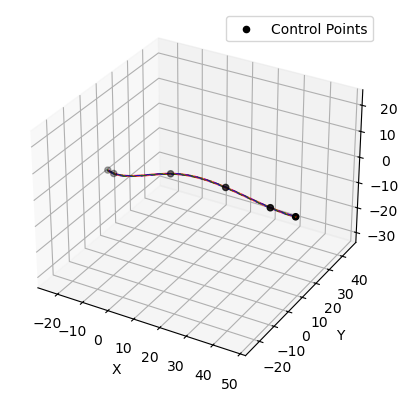

In [51]:
spline = mdna.SplineFrames(points)
spline.plot_frames(control_points=True)

In [52]:

dna = mdna.StructureGenerator(spline)
dna_traj = dna.get_traj()
# build = mdna.Build(dna_a=dna)
# dna = build.equilibrate(endpoints_fixed=True)
# dna_traj = dna.get_traj()


GGATAAAACATATATCGGACGCTGCCCCGCTTGCTGGTAGACCGTATGGCGGCCAAACGAAAAAGCTCAGAGGAATTCCGGGTGGACACTATAGTTGTGGGAACGGTGACACTCCCAGCCGGGTGATACCGTTGCTCTCGGAAAGGCTTAACTATTCATGTAATTTTGTGCACACCCCGGAATAGATTGCGCGTTGCTAGACATATTGCTCA


In [55]:

traj.save('lateral_filament_unoptimized_piecesDNA.pdb')

In [54]:
protein = traj.atom_slice(traj.top.select('protein'))
protein.save('lateral_filament_unoptimized_noDNA.pdb')
new_traj = dna_traj.stack(protein)   
new_traj.save('lateral_filament_unoptimized.pdb')
view = nv.show_mdtraj(new_traj)
view

NGLWidget()

(-23.159539508819577,
 44.08972864151001,
 -24.228127765655515,
 43.02114038467407,
 -25.04705283641815,
 25.38989827632904)

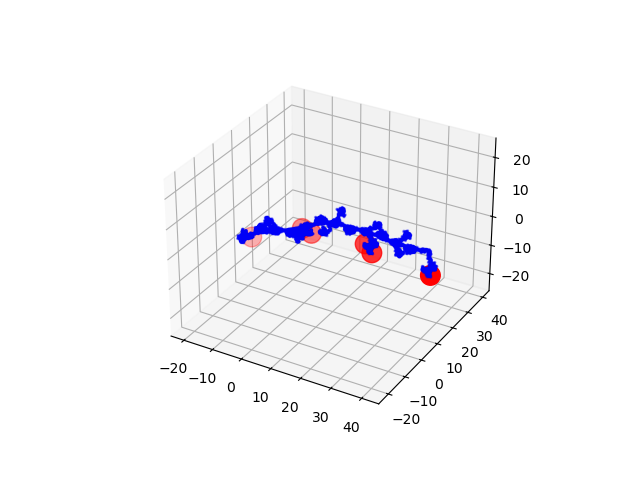

In [6]:
%matplotlib ipympl
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(points[:,0], points[:,1], points[:,2], c='r', marker='o',s=200)
xyz = traj.xyz[0]
ax.scatter(xyz[:,0], xyz[:,1], xyz[:,2], c='b', marker='o',alpha=0.1,s=1) 
ax.axis('equal')


In [7]:
nuc_a = mdna.NucleicFrames(traj, DNA_chainids[0])
nuc_b = mdna.NucleicFrames(traj, DNA_chainids[1])

frames_a = np.squeeze(nuc_a.mean_reference_frames)
frames_b = np.squeeze(nuc_b.mean_reference_frames)
dna_a = mdna.StructureGenerator(frames=frames_a)
dna_b = mdna.StructureGenerator(frames=frames_b)

build = mdna.Build(dna_a=dna_a,dna_b=dna_b)

CAGTAAAATGCT
CCACTTGGAACC


In [8]:
build.connect()

Optimal BP: 63, Twist Difference per BP: 0.475 degrees
f [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86]
c 87
a 12
b 12


/Users/thor/surfdrive/Projects/PMCpy/pmcpy/SO3/so3/SE3.py:17: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (Array(float64, 2, 'C', False, aligned=True), Array(float64, 1, 'A', False, aligned=True))
  inv[:3,3]  = -inv[:3,:3]@g[:3,3]


cycle 0: 
16 moves initated
E = 1145.5349293549968 kT
E = 546.3848877130035 kT
E = 522.1183707929371 kT
E = 468.46909612288016 kT
E = 446.59661749948265 kT
E = 442.1620812041325 kT
E = 427.87665118537063 kT
E = 415.0927981374644 kT
E = 410.21124350379 kT
E = 395.5900628366887 kT
E = 396.5893413871002 kT
16 moves initated
GCCGGGTCCTTATTGAGTGTGCACCACCGTCGTCCGAGGGTCGGTCTTCCCTGTTCAACGCGTTTGTAAGTGGAAAGAATACATATA


In [9]:
view = nv.show_mdtraj(build.get_MC_traj())  
view

NGLWidget(max_frame=225)

In [10]:
dna_c = build.get_traj()
nuc_c = mdna.NucleicFrames(dna_c, chainids=[0,1])
nuc_d = mdna.NucleicFrames(traj, chainids=DNA_chainids[2])

frames_c = np.squeeze(nuc_c.mean_reference_frames)
frames_d = np.squeeze(nuc_d.mean_reference_frames)

dna_c = mdna.StructureGenerator(frames=frames_c)
dna_d = mdna.StructureGenerator(frames=frames_d)

build = mdna.Build(dna_a=dna_c,dna_b=dna_d)

TAGAAGGTAAGTAACACTTGTATTCGGCACTGGATTAGGATCATGCGCTCATTGTTTGTTGGAGAGCGTGGCTGCATCGTCCGCATC
ACAGCTCACGGT


In [11]:
build.connect()
view = nv.show_mdtraj(build.get_MC_traj())  
view

Optimal BP: 64, Twist Difference per BP: -0.213 degrees
f [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161]
c 162
a 87
b 12
cycle 0: 
16 moves initated
E = 1557.6926355858013 kT
E = 877.9504812797007 kT
E = 828.2254998500146 kT
E = 804.9610113950862 kT
E = 792.5775687230387 kT
E = 780.123536341483 kT
E = 778.0459317751786 kT
E = 780.4248586612867 kT
16 moves initated
CTAGTGCCAAGCGAACGCGACGGGAACCCATGATTCAAACCTTTTTTTTATCTTACGATAAAGTCGCGCTGGTCCCCCAGACTGAGGGATCAACTAAACTCGCTGGTATTGGGGGATCGCATCCCGCGACACAAAAAGCGTCGGTTGAAAAGCACCTATTAG


NGLWidget(max_frame=150)

In [13]:
protein = traj.atom_slice(traj.top.select('protein'))
dna = build.get_traj()
new_traj = dna.stack(protein)   

view = nv.show_mdtraj(new_traj)
view

NGLWidget()

In [15]:
dna_e = build.get_traj()
nuc_e = mdna.NucleicFrames(dna_e, chainids=[0,1])
nuc_f = mdna.NucleicFrames(traj, chainids=DNA_chainids[3])

frames_e = np.squeeze(nuc_e.mean_reference_frames)
frames_f = np.squeeze(nuc_f.mean_reference_frames)

dna_e = mdna.StructureGenerator(frames=frames_e)
dna_f = mdna.StructureGenerator(frames=frames_f)

build = mdna.Build(dna_a=dna_e,dna_b=dna_f)

CATCTCTGCCACGTCTCGCAAGTGGTGCTTTACTTACGAGGGTAGATCCTGGACGTGGTCCATTAAACACATCCATGAATAGGGATTACGCGGCAACCCCATCGTTTGGATCACAACTAACTCGCCCGTACCAAAGCCGCTCATTACAATACGGGACCAAGT
ACCGTACGAATC


In [16]:
build.connect()

Optimal BP: 74, Twist Difference per BP: 0.156 degrees
f [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247]
c 248
a 162
b 12
cycle 0: 
19 moves initated
E = 2575.233139834083 kT
E = 1590.3117208931008 kT
E = 1404.086726998952 kT
E = 1337.9792765902646 kT
E = 1338.708875601474 kT
19 moves initated
TG

In [17]:
protein = traj.atom_slice(traj.top.select('protein'))
dna_complex = build.get_traj()
newest_traj = dna.stack(protein)   

view = nv.show_mdtraj(newest_traj)
view

NGLWidget()

In [ ]:
new_traj.save('lateral_filament.pdb')

Point [ 6 22 13] is inside voxel space. Moving to nearest zero voxel.
Point [ 6 22 13], 10493 is nearest zero voxel (6, 21, 13), 10453
Point [18 28 26] is inside voxel space. Moving to nearest zero voxel.
Point [18 28 26], 29946 is nearest zero voxel (18, 29, 26), 29986
Point [16 23 28] is inside voxel space. Moving to nearest zero voxel.
Point [16 23 28], 26548 is nearest zero voxel (15, 23, 28), 24948
Point [20 12 18] is inside voxel space. Moving to nearest zero voxel.
Point [20 12 18], 32498 is nearest zero voxel (20, 12, 17), 32497
Point [20 12 23] is inside voxel space. Moving to nearest zero voxel.
Point [20 12 23], 32503 is nearest zero voxel (20, 12, 24), 32504
Point [38 23 11] is inside voxel space. Moving to nearest zero voxel.
Point [38 23 11], 61731 is nearest zero voxel (38, 23, 12), 61732


array([[ 9.280302  , 16.616684  ,  5.9708695 ],
       [ 8.653871  , 16.616684  ,  5.9708695 ],
       [ 8.653871  , 16.616684  ,  5.344438  ],
       [ 8.027439  , 16.616684  ,  5.344438  ],
       [ 8.027439  , 15.990252  ,  5.344438  ],
       [ 8.027439  , 15.36382   ,  5.344438  ],
       [ 8.027439  , 15.36382   ,  4.7180066 ],
       [ 7.4010077 , 15.36382   ,  4.7180066 ],
       [ 7.4010077 , 14.737389  ,  4.7180066 ],
       [ 7.4010077 , 14.737389  ,  4.091575  ],
       [ 6.774576  , 14.737389  ,  4.091575  ],
       [ 6.774576  , 14.110957  ,  4.091575  ],
       [ 6.774576  , 14.110957  ,  3.4651437 ],
       [ 6.1481447 , 14.110957  ,  3.4651437 ],
       [ 6.1481447 , 13.484526  ,  3.4651437 ],
       [ 6.1481447 , 13.484526  ,  2.8387122 ],
       [ 5.5217133 , 13.484526  ,  2.8387122 ],
       [ 5.5217133 , 12.858094  ,  2.8387122 ],
       [ 5.5217133 , 12.858094  ,  2.2122808 ],
       [ 4.895282  , 12.858094  ,  2.2122808 ],
       [ 4.895282  , 12.231663  ,  2.212

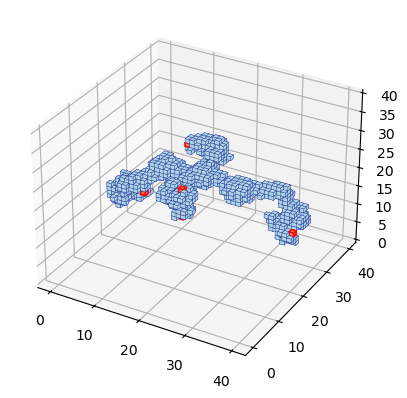

In [ ]:
V = Voxelizer(xyz,n=40)
V.process_points(points=points)
V.plot(control_points=True)

path = V.find_path(ordered=True)
xyz_path = V.voxel_to_xyz(path)
xyz_path = np.array(xyz_path)
xyz_path